In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
# Download the file
zipfile = tf.keras.utils.get_file( 'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

filepath = os.path.dirname(zipfile)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [0]:
def unicodetoascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')
  
def preprocess(word):
  word = unicodetoascii(word.lower().strip())
  word = re.sub(r"([?.!,¿])", r" \1 ", word)
  word = re.sub(r'[" "]+', " ", word)
  word = re.sub(r"[^a-zA-Z?.!,¿]+", " ", word)
  word = word.strip()
  word = '<start> ' + word + ' <end>'
  return word

In [4]:
englishsen = u"May I borrow this book?"
spanishsen = u"¿Puedo tomar prestado este libro?"
print(preprocess(englishsen))
print(preprocess(spanishsen).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [0]:

def createdataset(path, examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  wordpairs = [[preprocess(w) for w in l.split('\t')]  for l in lines[:examples]]
  return zip(*wordpairs)

In [7]:
en, sp = createdataset(filepath, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [0]:
def tokenize(sentence):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  tokenizer.fit_on_texts(sentence)
  tensor = tokenizer.texts_to_sequences(sentence)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor, tokenizer

In [0]:
def loaddata(path, examples=None):
  targetlang, inputlang = createdataset(path, examples)
  inputtensor, inplangtoken = tokenize(inputlang)
  targettensor, targlangtoken = tokenize(targetlang)
  return inputtensor, targettensor, inplangtoken, targlangtoken

In [0]:
numexamples =30000
inputtensor, targettensor, inplang, targlang = loaddata(filepath, numexamples)

targetlength, inputlength = targettensor.shape[1], inputtensor.shape[1]

In [14]:
# Create the training and test dataset
inptensortrain, inptensorval, targettensortrain, targettensorval = train_test_split(inputtensor, targettensor, test_size=0.2)
print(len(inptensortrain), len(targettensortrain), len(inptensorval), len(targettensorval))

24000 24000 6000 6000


In [0]:
def convert(lang, tensor):
  for i in tensor:
    if i!=0:
      print ("%d - %s" % (i, lang.index_word[i]))

In [19]:
print ("input index to word mapping")
convert(inplang, inptensortrain[0])
print ("target index to word mapping")
convert(targlang, targettensortrain[0])

input index to word mapping
1 - <start>
4 - tom
77 - ya
67 - ha
966 - tenido
433 - suficiente
3 - .
2 - <end>
target index to word mapping
1 - <start>
5 - tom
51 - has
99 - had
392 - enough
3 - .
2 - <end>


In [0]:
buffersize = len(inputtensor)
batchsize = 64
stepsepoch = len(inptensortrain)//batchsize
embeddim = 256
units = 1024
vocabinpsize = len(inplang.word_index)+1
vocabtarsize = len(targlang.word_index)+1
dataset = tf.data.Dataset.from_tensor_slices((inptensortrain, targettensortrain)).shuffle(buffersize)
dataset = dataset.batch(batchsize, drop_remainder=True)

In [21]:
eginputbatch, egtargetbatch = next(iter(dataset))
eginputbatch.shape, egtargetbatch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [0]:
class encoder(tf.keras.Model):
  def __init__(self, vocabsize, embeddim, encunits, batchsz):
    super(encoder, self).__init__()
    self.batchsz = batchsz
    self.encunits = encunits
    self.embedding = tf.keras.layers.Embedding(vocabsize, embeddim)
    self.gru = tf.keras.layers.GRU(self.encunits,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initializehiddenstate(self):
    return tf.zeros((self.batchsz, self.encunits))

In [25]:
encoder = encoder(vocabinpsize, embeddim, units, batchsize)
samplehidden = encoder.initializehiddenstate()
sampleoutput, samplehidden = encoder(eginputbatch, samplehidden)
print ('encoder output shape: (batch size, sequence length, units) {}'.format(sampleoutput.shape))
print ('encoder hidden state shape: (batch size, units) {}'.format(samplehidden.shape))

encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
encoder hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [28]:
attentionlayer = BahdanauAttention(10)
attentionresult, attentionweights = attentionlayer(samplehidden, sampleoutput)

print("attention result shape: (batch size, units) {}".format(attentionresult.shape))
print("attention weights shape: (batch_size, sequence_length, 1) {}".format(attentionweights.shape))

attention result shape: (batch size, units) (64, 1024)
attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [0]:
class decoder(tf.keras.Model):
  def __init__(self, vocabsize, embeddingdim, decunits, batch_sz):
    super(decoder, self).__init__()
    self.batch_sz = batch_sz
    self.decunits = decunits
    self.embedding = tf.keras.layers.Embedding(vocabsize, embeddingdim)
    self.gru = tf.keras.layers.GRU(self.decunits,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocabsize)
    self.attention = BahdanauAttention(self.decunits)

  def call(self, x, hidden, encoutput):
    contextvector, attentionweights = self.attention(hidden, encoutput)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(contextvector, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attentionweights

In [35]:
decoder = decoder(vocabtarsize, embeddim, units, batchsize)

sampledecoderoutput, _, _ = decoder(tf.random.uniform((batchsize, 1)),samplehidden, sampleoutput)

print ('decoder output shape: (batch size, vocab size) {}'.format(sampledecoderoutput.shape))

decoder output shape: (batch size, vocab size) (64, 4935)


In [0]:
optimizer = tf.keras.optimizers.Adam()
lossobject = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def lossfunction(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = lossobject(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [0]:
checkpointdir = './training_checkpoints'
checkpointprefix = os.path.join(checkpointdir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder)

In [0]:
@tf.function
def trainstep(inp, targ, enchidden):
  loss = 0
  with tf.GradientTape() as tape:
    encoutput, enchidden = encoder(inp, enchidden)
    dechidden = enchidden
    decinput = tf.expand_dims([targlang.word_index['<start>']] * batchsize, 1)
    for t in range(1, targ.shape[1]):
      predictions, dechidden, _ = decoder(decinput, dechidden, encoutput)
      loss += lossfunction(targ[:, t], predictions)
      decinput = tf.expand_dims(targ[:, t], 1)

  batchloss = (loss / int(targ.shape[1]))
  variab = encoder.trainable_variables + decoder.trainable_variables
  grads = tape.gradient(loss, variab)
  optimizer.apply_gradients(zip(grads, variab))
  return batchloss

In [49]:
epochs = 10
for epoch in range(epochs):
  start = time.time()
  enchidden = encoder.initializehiddenstate()
  totalloss = 0
  for (batch, (inp, targ)) in enumerate(dataset.take(stepsepoch)):
    batchloss = trainstep(inp, targ, enchidden)
    totalloss += batchloss
    if batch % 100 == 0:
      print('epoch {} batch {} loss {:.4f}'.format(epoch + 1,batch,batchloss.numpy()))
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpointprefix)

  print('epoch {} loss {:.4f}'.format(epoch + 1,totalloss / stepsepoch))
  print('time taken for 1 epoch {} sec\n'.format(time.time() - start))

epoch 1 batch 0 loss 1.1421
epoch 1 batch 100 loss 1.0136
epoch 1 batch 200 loss 1.0638
epoch 1 batch 300 loss 0.9807
epoch 1 loss 0.9811
time taken for 1 epoch 46.13647747039795 sec

epoch 2 batch 0 loss 0.8039
epoch 2 batch 100 loss 0.6715
epoch 2 batch 200 loss 0.5607
epoch 2 batch 300 loss 0.6268
epoch 2 loss 0.6603
time taken for 1 epoch 46.683907985687256 sec

epoch 3 batch 0 loss 0.4054
epoch 3 batch 100 loss 0.4608
epoch 3 batch 200 loss 0.4049
epoch 3 batch 300 loss 0.3770
epoch 3 loss 0.4519
time taken for 1 epoch 46.26522755622864 sec

epoch 4 batch 0 loss 0.2139
epoch 4 batch 100 loss 0.2650
epoch 4 batch 200 loss 0.2896
epoch 4 batch 300 loss 0.3041
epoch 4 loss 0.3116
time taken for 1 epoch 46.48322010040283 sec

epoch 5 batch 0 loss 0.1971
epoch 5 batch 100 loss 0.2012
epoch 5 batch 200 loss 0.2191
epoch 5 batch 300 loss 0.2740
epoch 5 loss 0.2235
time taken for 1 epoch 45.98759055137634 sec

epoch 6 batch 0 loss 0.1002
epoch 6 batch 100 loss 0.1760
epoch 6 batch 200 los

In [0]:
def evaluate(sentence):
  attentionplot = np.zeros((targetlength, inputlength))
  sentence = preprocess(sentence)
  inputs = [inplang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=inputlength,padding='post')
  inputs = tf.convert_to_tensor(inputs)
  result = ''
  hidden = [tf.zeros((1, units))]
  encout, enchidden = encoder(inputs, hidden)
  dechidden = enchidden
  decinput = tf.expand_dims([targlang.word_index['<start>']], 0)
  for t in range(inputlength):
    predictions, dechidden, attentionweights = decoder(decinput,dechidden,encout)
    attentionweights = tf.reshape(attentionweights, (-1, ))
    attentionplot[t] = attentionweights.numpy()
    predictedid = tf.argmax(predictions[0]).numpy()
    result += targlang.index_word[predictedid] + ' '
    if targlang.index_word[predictedid] == '<end>':
      return result, sentence, attentionplot
    decinput = tf.expand_dims([predictedid], 0)
  return result, sentence, attentionplot

In [0]:
def plotattention(attention, sentence, predictedsentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')
  fontdict = {'fontsize': 14}
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predictedsentence, fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attentionplot = evaluate(sentence)
  print('input: %s' % (sentence))
  print('predicted translation: {}'.format(result))
  attentionplot = attentionplot[:len(result.split(' ')), :len(sentence.split(' '))]
  plotattention(attentionplot, sentence.split(' '), result.split(' '))

In [53]:
checkpoint.restore(tf.train.latest_checkpoint(checkpointdir))

input: <start> hace mucho frio aqui . <end>
predicted translation: it s very cold here . <end> 


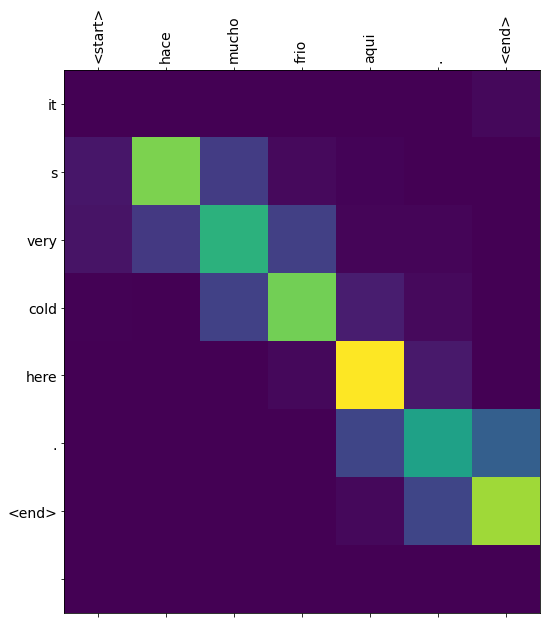

In [70]:
translate(u'hace mucho frio aqui.')

input: <start> trata de averiguarlo . <end>
predicted translation: try on a break . <end> 


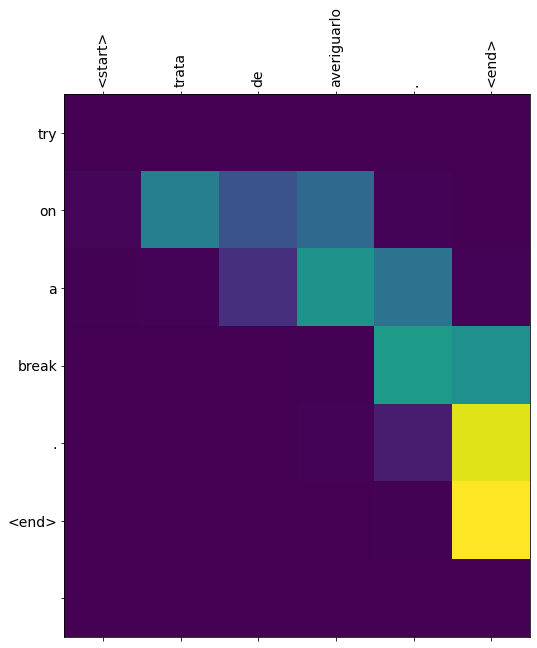

In [71]:
translate(u'trata de averiguarlo.')
